# construct mock1
This is a sample that includes galaxies at multiple redshifts

In [1]:
import os
import numpy as np 

In [2]:
from astropy import units as u
from astropy.cosmology import Planck13

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# sample the "true" luminosity function 

In [4]:
def LF(Muv, z, phi): 
    alpha, beta, gamma, Muv_s = phi
    return (10**(gamma * (z - 9.)))/(10**(0.4*(alpha + 1)*(Muv - Muv_s) + 10**(0.4*(beta + 1)*(Muv - Muv_s))))


phi_amp = 6e-3
phi_true = np.array([-1.65, -1.5, -0.2, -19.5]) # fit by eye to zeus21 output

In [5]:
import zeus21
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

CosmoParams_input = zeus21.Cosmo_Parameters_Input(zmin_CLASS=0.0) #make sure to provide zmin_CLASS lower than standard (5.0) if you want lower z results (eg HMFs)

CosmoParams, ClassyCosmo, CorrFclass ,HMFintclass =  zeus21.cosmo_wrapper(CosmoParams_input)

AstroParams_std = zeus21.Astro_Parameters(CosmoParams, accretion_model=0) #made accretion_model exponential, like in the paper (2306.09403)

#make mock
Nz=133
NMUV=300

zlist = np.linspace(4, 15, Nz)
zwidths = np.diff(zlist)
zwidths = np.append(zwidths,zwidths[-1])
dzuvlf = np.mean(zwidths) #just for UVLF calculation

MUVcenters = np.linspace(-15.,-24.,NMUV) #centers of bins
MUVwidths = -np.diff(MUVcenters)
MUVwidths = np.append(MUVwidths,MUVwidths[-1])

UVLFlist = np.array([phi_amp * LF(MUVcenters, z, phi_true) for z in zlist])


OmegaSurvey = 38.0*(1./60.)**2 * (np.pi/180)**2 #rad^2
#OmegaSurvey = 0.5 * (np.pi/180)**2 #rad^2
DeltaVlist = OmegaSurvey*CosmoParams.chiofzint(zlist)**2*dzuvlf/CosmoParams.Hofzint(zlist)

lambdalist = UVLFlist * np.outer(DeltaVlist, MUVwidths) #avg for Poisson

Nsample = np.random.poisson(lambdalist, ((Nz,NMUV)))

In [6]:
Ngal = 0
Ngaltot = np.sum(Nsample)

mock = []
for iz,zz in enumerate(zlist):
    for iMUV, MUV in enumerate(MUVcenters):
        for jgal in range(Nsample[iz,iMUV]):
            Ngal+=1
            mock = mock + [[zz, MUV]]

print(Ngal, Ngaltot)
mock = np.array(mock)

174564 174564


(-14.0, -22.0)

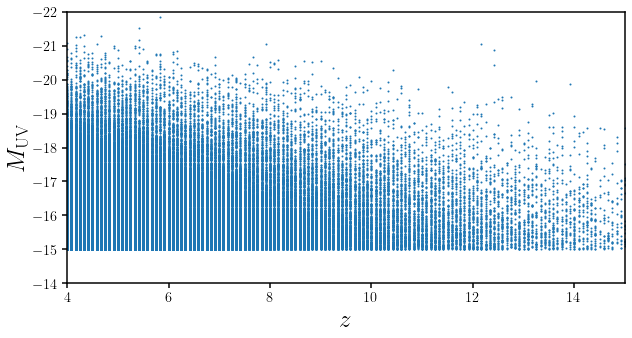

In [7]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(mock[:,0], mock[:,1], s=1)
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

## implement $z$ selection function
This is supposedly from simulations.

In [8]:
prob_z0 = np.exp(-(mock[:,0] - 7.0)**2)
select_z0 = prob_z0 > np.random.uniform(size=mock.shape[0])
print(np.mean(select_z0))
print(np.sum(select_z0))

prob_z1 = np.exp(-(mock[:,0] - 9.0)**2)
select_z1 = (prob_z1 > np.random.uniform(size=mock.shape[0])) & (~select_z0)
print(np.mean(select_z1))
print(np.sum(select_z1))

prob_z2 = np.exp(-(mock[:,0] - 11.0)**2)
select_z2 = (prob_z2 > np.random.uniform(size=mock.shape[0])) & (~select_z0) & (~select_z1)
print(np.mean(select_z2))
print(np.sum(select_z2))

0.19300657638459248
33692
0.052444948557549095
9155
0.017798629728924636
3107


(0.0, 1.1)

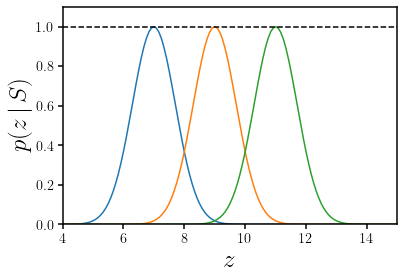

In [9]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)
sub.plot(mock[:,0], prob_z0)
sub.plot(mock[:,0], prob_z1)
sub.plot(mock[:,0], prob_z2)
sub.plot([0., 100], [1., 1.], c='k', ls='--')
sub.set_xlabel('$z$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylabel('$p(z\,|\,S)$', fontsize=25)
sub.set_ylim(0., 1.1)

(-14.0, -22.0)

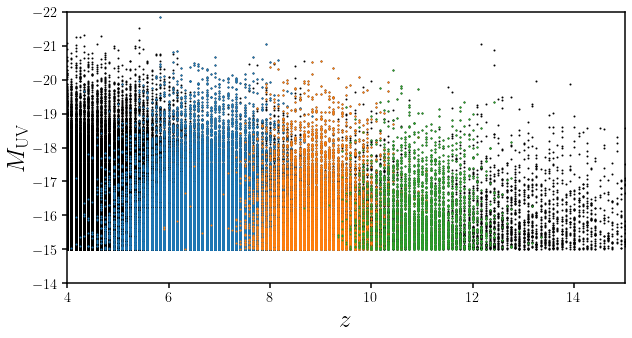

In [10]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(mock[:,0], mock[:,1], s=1, c='k')
sub.scatter(mock[:,0][select_z0], mock[:,1][select_z0], s=1, c='C0')
sub.scatter(mock[:,0][select_z1], mock[:,1][select_z1], s=1, c='C1')
sub.scatter(mock[:,0][select_z2], mock[:,1][select_z2], s=1, c='C2')
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

# implement $m_{\rm UV}$ cut 

In [11]:
from scipy.special import erf

In [12]:
def S_muv(muv, c_erf0=0.9, c_erf1 = 32):
    return 0.5*(1-erf(c_erf0*(muv - c_erf1)))

In [13]:
# convert mock absolute magnitude to apparent magnitudes
mock_muv = mock[:,1] + 5 * np.log10(Planck13.luminosity_distance(mock[:,0]).to(u.pc).value/10.)

# m_uv selection weights 
w_muv_select = S_muv(mock_muv, c_erf0=1., c_erf1=32)

In [14]:
select_muv = np.random.uniform(size=mock.shape[0]) < w_muv_select
print(np.mean(select_z0 & select_muv))
print(np.sum(select_z0 & select_muv))

0.03248092390183543
5670


(-14.0, -22.0)

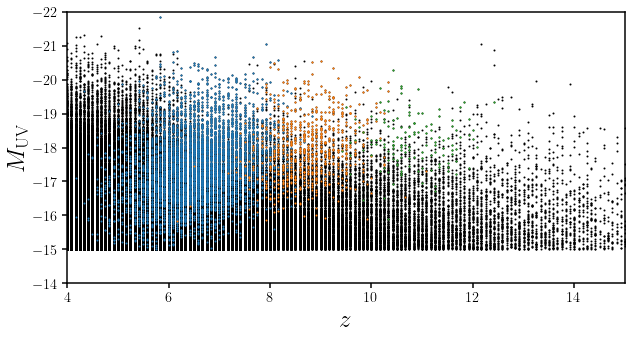

In [22]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(mock[:,0], mock[:,1], s=1, c='k')
sub.scatter(mock[:,0][select_z0 & select_muv], mock[:,1][select_z0 & select_muv], s=1, c='C0')
sub.scatter(mock[:,0][select_z1 & select_muv], mock[:,1][select_z1 & select_muv], s=1, c='C1')
sub.scatter(mock[:,0][select_z2 & select_muv], mock[:,1][select_z2 & select_muv], s=1, c='C2')

sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

# calculate $p(\theta\,|\,S)$

In [35]:
unif_Muv = np.random.uniform(-22, -15, size=int(1e7))
unif_z = np.random.uniform(2., 15, size=int(1e7))
unif_muv = unif_Muv + 5 * np.log10(Planck13.luminosity_distance(unif_z).to(u.pc).value/10.)

unif_select_z0 = np.exp(-(unif_z - 7.0)**2) > np.random.uniform(size=int(1e7))
unif_select_z1 = np.exp(-(unif_z - 9.0)**2) > np.random.uniform(size=int(1e7))
unif_select_z2 = np.exp(-(unif_z - 11.0)**2) > np.random.uniform(size=int(1e7))
unif_select_muv = np.random.uniform(size=len(unif_muv)) < S_muv(unif_muv, c_erf0=1., c_erf1=32)

In [39]:
h, bx, by = np.histogram2d(unif_z, unif_Muv, bins=[100, 100], range=[(1.99, 15.01), (-22.01, -14.99)])
h_select0, _, _ = np.histogram2d(unif_z[unif_select_z0 & unif_select_muv], unif_Muv[unif_select_z0 & unif_select_muv],
                                bins=[100, 100], range=[(1.99, 15.01), (-22.01, -14.99)])
h_select1, _, _ = np.histogram2d(unif_z[unif_select_z1 & unif_select_muv], unif_Muv[unif_select_z1 & unif_select_muv],
                                bins=[100, 100], range=[(1.99, 15.01), (-22.01, -14.99)])
h_select2, _, _ = np.histogram2d(unif_z[unif_select_z2 & unif_select_muv], unif_Muv[unif_select_z2 & unif_select_muv],
                                bins=[100, 100], range=[(1.99, 15.01), (-22.01, -14.99)])

(-15.0, -22.0)

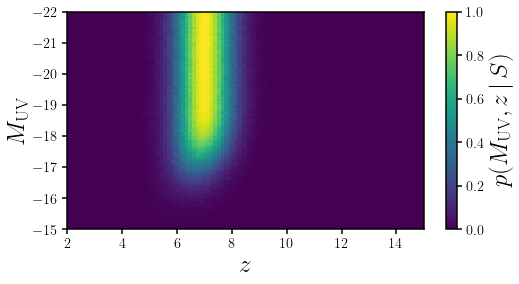

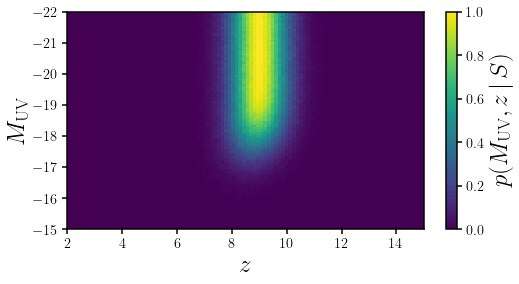

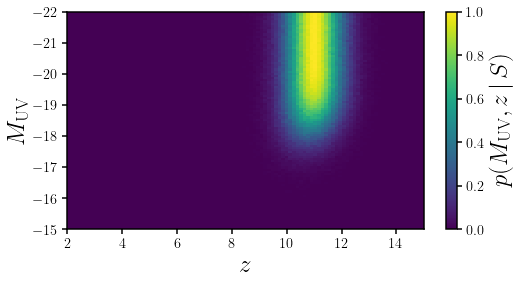

In [40]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
X, Y = np.meshgrid(bx, by)
p = sub.pcolormesh(X, Y, (h_select0/h).T, vmin=0., vmax=1)
plt.colorbar(p).set_label(r'$p(M_{\rm UV}, z\,|\,S)$', size=25)
sub.set_xlabel('$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_ylim(-15, -22)

fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
X, Y = np.meshgrid(bx, by)
p = sub.pcolormesh(X, Y, (h_select1/h).T, vmin=0., vmax=1)
plt.colorbar(p).set_label(r'$p(M_{\rm UV}, z\,|\,S)$', size=25)
sub.set_xlabel('$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_ylim(-15, -22)

fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
X, Y = np.meshgrid(bx, by)
p = sub.pcolormesh(X, Y, (h_select2/h).T, vmin=0., vmax=1)
plt.colorbar(p).set_label(r'$p(M_{\rm UV}, z\,|\,S)$', size=25)
sub.set_xlabel('$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_ylim(-15, -22)

In [41]:
np.save('/Users/chahah/data/binsin/mock1_select.bx.npy', bx)
np.save('/Users/chahah/data/binsin/mock1_select.by.npy', by)
np.save('/Users/chahah/data/binsin/mock1_select0.p_theta_S.npy', (h_select0/h).T)
np.save('/Users/chahah/data/binsin/mock1_select1.p_theta_S.npy', (h_select1/h).T)
np.save('/Users/chahah/data/binsin/mock1_select2.p_theta_S.npy', (h_select2/h).T)

## add noise based on Finkelstein *et al.* (2023)
https://ui.adsabs.harvard.edu/abs/2023ApJ...946L..13F/abstract

In [23]:
ceers_z9 = np.loadtxt('/Users/chahah/data/binsin/ceers_S9_table.dat', skiprows=1)

(-14.0, -22.0)

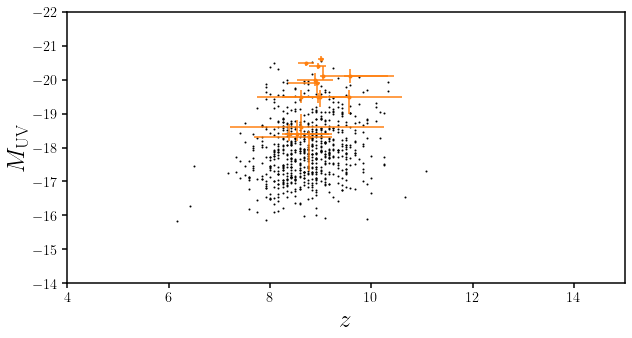

In [25]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(mock[:,0][select_z1 & select_muv], mock[:,1][select_z1 & select_muv], s=1, c='k')
sub.errorbar(ceers_z9[:,0], ceers_z9[:,3], 
             xerr=[ceers_z9[:,1], ceers_z9[:,2]], yerr=[ceers_z9[:,4], ceers_z9[:,5]], fmt='.C1')
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

In [29]:
mock_Muv_1sig = 0.12 + 0.0*np.random.normal(size=mock.shape[0])
mock_Muv = mock[:,1] + mock_Muv_1sig * np.random.normal(size=mock.shape[0])

(-14.0, -22.0)

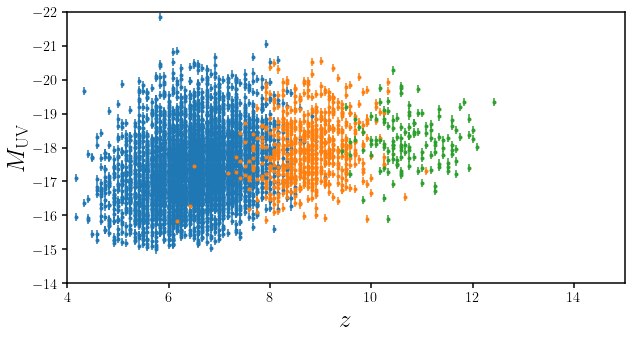

In [30]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.errorbar(mock[:,0][select_z0 & select_muv], mock[:,1][select_z0 & select_muv], 
             yerr=mock_Muv_1sig[select_z0 & select_muv], fmt='.C0')
sub.errorbar(mock[:,0][select_z1 & select_muv], mock[:,1][select_z1 & select_muv], 
             yerr=mock_Muv_1sig[select_z1 & select_muv], fmt='.C1')
sub.errorbar(mock[:,0][select_z2 & select_muv], mock[:,1][select_z2 & select_muv], 
             yerr=mock_Muv_1sig[select_z2 & select_muv], fmt='.C2')

sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

## lets add photo-$z$ noise

In [31]:
mock_photoz_1sig = (0.45 + 0.35 * np.random.normal(size=mock.shape[0])).clip(0.05, None) 

In [32]:
mock_photoz = mock[:,0] + mock_photoz_1sig * np.random.normal(size=mock.shape[0])

(-14.0, -22.0)

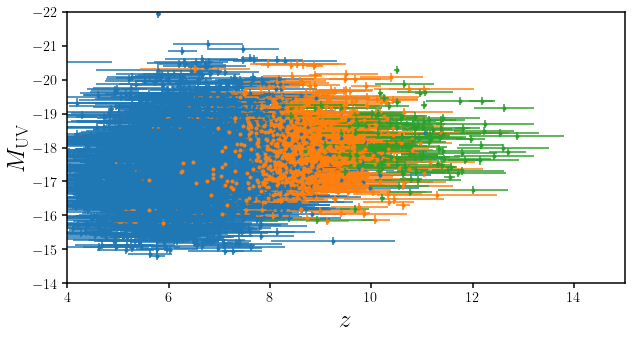

In [33]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.errorbar(mock_photoz[select_z0 & select_muv], mock_Muv[select_z0 & select_muv], 
             xerr=mock_photoz_1sig[select_z0 & select_muv], 
             yerr=mock_Muv_1sig[select_z0 & select_muv], fmt='.C0')
sub.errorbar(mock_photoz[select_z1 & select_muv], mock_Muv[select_z1 & select_muv], 
             xerr=mock_photoz_1sig[select_z1 & select_muv], 
             yerr=mock_Muv_1sig[select_z1 & select_muv], fmt='.C1')
sub.errorbar(mock_photoz[select_z2 & select_muv], mock_Muv[select_z2 & select_muv], 
             xerr=mock_photoz_1sig[select_z2 & select_muv], 
             yerr=mock_Muv_1sig[select_z2 & select_muv], fmt='.C2')
#sub.errorbar(ceers_z9[:,0], ceers_z9[:,3], 
#             xerr=[ceers_z9[:,1], ceers_z9[:,2]], yerr=[ceers_z9[:,4], ceers_z9[:,5]], fmt='.C1')
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

## save mock0

In [34]:
np.savetxt('/Users/chahah/data/binsin/mock1z0.dat',
           np.array([mock[:,0][select_z0 & select_muv], 
                     mock[:,1][select_z0 & select_muv], 
                     mock_photoz[select_z0 & select_muv], 
                     mock_Muv[select_z0 & select_muv], 
                     mock_photoz_1sig[select_z0 & select_muv], 
                     mock_Muv_1sig[select_z0 & select_muv], 
                     prob_z0[select_z0 & select_muv], 
                     w_muv_select[select_z0 & select_muv]
                    ]).T, 
           header='z_true, Muv_true, z, Muv, sig_z, sig_Muv, w_photoz, w_muv')

np.savetxt('/Users/chahah/data/binsin/mock1z1.dat',
           np.array([mock[:,0][select_z1 & select_muv], 
                     mock[:,1][select_z1 & select_muv], 
                     mock_photoz[select_z1 & select_muv], 
                     mock_Muv[select_z1 & select_muv], 
                     mock_photoz_1sig[select_z1 & select_muv], 
                     mock_Muv_1sig[select_z1 & select_muv], 
                     prob_z1[select_z1 & select_muv], 
                     w_muv_select[select_z1 & select_muv]
                    ]).T, 
           header='z_true, Muv_true, z, Muv, sig_z, sig_Muv, w_photoz, w_muv')

np.savetxt('/Users/chahah/data/binsin/mock1z2.dat',
           np.array([mock[:,0][select_z2 & select_muv], 
                     mock[:,1][select_z2 & select_muv], 
                     mock_photoz[select_z2 & select_muv], 
                     mock_Muv[select_z2 & select_muv], 
                     mock_photoz_1sig[select_z2 & select_muv], 
                     mock_Muv_1sig[select_z2 & select_muv], 
                     prob_z2[select_z2 & select_muv], 
                     w_muv_select[select_z2 & select_muv]
                    ]).T, 
           header='z_true, Muv_true, z, Muv, sig_z, sig_Muv, w_photoz, w_muv')